<a href="https://colab.research.google.com/github/Sourav-Manik/Data-Science-Assignment/blob/main/Assignment_18_Forecasting_CocoCola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as category_encoders
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#CocaCola Data

In [2]:
CC = pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
CC.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


EDA

In [3]:
CC.shape

(42, 2)

In [4]:
CC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [5]:
CC.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
# replace _ with space
CC['Quarter'] = CC['Quarter'].str.replace('_',' ')

CC['Quarter'] = pd.to_datetime(
    CC['Quarter'].str.replace(r'(Q\d) (\d+)', r'19\2-\1'), errors='coerce')
CC.head()

,Quarter,Sales
0,1986-01-01,1734.827000
1,1986-04-01,2244.960999
2,1986-07-01,2533.804993
3,1986-10-01,2154.962997
4,1987-01-01,1547.818996


In [7]:
CC["Date"] = pd.to_datetime(CC.Quarter,format="%b-%y")
CC["month"] = CC.Date.dt.strftime("%b")
CC["year"] = CC.Date.dt.strftime("%Y") 

In [8]:
CC.head()

,Quarter,Sales,Date,month,year
0,1986-01-01,1734.827000,1986-01-01,Jan,1986
1,1986-04-01,2244.960999,1986-04-01,Apr,1986
2,1986-07-01,2533.804993,1986-07-01,Jul,1986
3,1986-10-01,2154.962997,1986-10-01,Oct,1986
4,1987-01-01,1547.818996,1987-01-01,Jan,1987


Visulaization

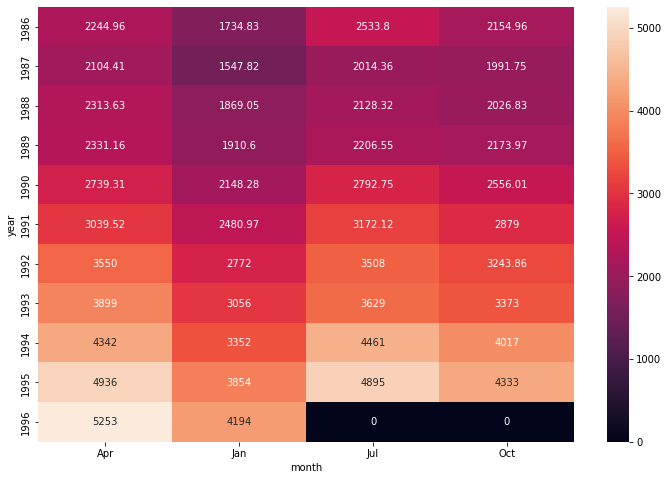

In [9]:
# Heatmap
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=CC,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

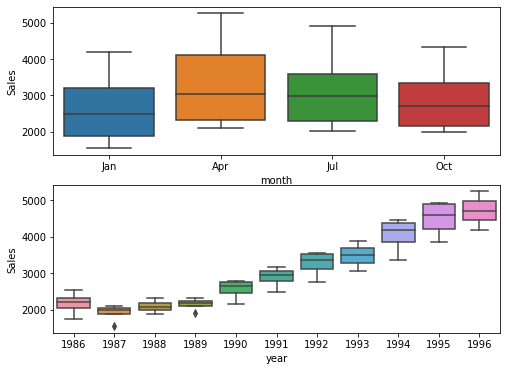

In [10]:
# Boxplot
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=CC)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=CC)

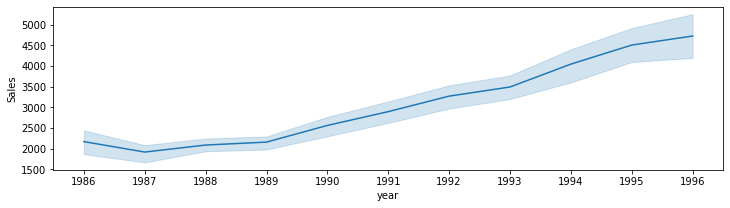

In [11]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Sales",data=CC)

In [12]:
#one hot encoding
encoding = category_encoders.OneHotEncoder(cols=['month'])

In [13]:
CC=encoding.fit_transform(CC)
CC.head()

,Quarter,Sales,Date,month_1,month_2,month_3,month_4,year
0,1986-01-01,1734.827000,1986-01-01,1,0,0,0,1986
1,1986-04-01,2244.960999,1986-04-01,0,1,0,0,1986
2,1986-07-01,2533.804993,1986-07-01,0,0,1,0,1986
3,1986-10-01,2154.962997,1986-10-01,0,0,0,1,1986
4,1987-01-01,1547.818996,1987-01-01,1,0,0,0,1987


In [14]:
CC.rename(columns={'month_1': 'Quarter_1', 'month_2': 'Quarter_2','month_3': 'Quarter_3', 'month_4': 'Quarter_4'}, inplace=True)

In [15]:
CC["t"] = np.arange(1,len(CC)+1)
CC["t_squared"] = CC["t"]*CC["t"]
CC["log_sales"] = np.log(CC["Sales"])

In [16]:
CC.head(5)

,Quarter,Sales,Date,Quarter_1,Quarter_2,Quarter_3,Quarter_4,year,t,t_squared,log_sales
0,1986-01-01,1734.827000,1986-01-01,1,0,0,0,1986,1,1,7.458663
1,1986-04-01,2244.960999,1986-04-01,0,1,0,0,1986,2,4,7.716443
2,1986-07-01,2533.804993,1986-07-01,0,0,1,0,1986,3,9,7.837477
3,1986-10-01,2154.962997,1986-10-01,0,0,0,1,1986,4,16,7.675529
4,1987-01-01,1547.818996,1987-01-01,1,0,0,0,1987,5,25,7.344602


Models

In [17]:
#Splitting data

Train = CC.head(32)
Test = CC.tail(10)

In [18]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

752.9233932767116

In [19]:
#Exponential

Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp


590.3316432076487

In [20]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

457.735735540752

In [21]:
#Additive seasonality 

add_sea = smf.ols('Sales~Quarter_1+Quarter_2+Quarter_3+Quarter_4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Quarter_1','Quarter_2','Quarter_3','Quarter_4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1850.466546185835

In [22]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Quarter_1+Quarter_2+Quarter_3+Quarter_4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Quarter_1','Quarter_2','Quarter_3','Quarter_4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

277.351077112853

In [23]:
#Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Quarter_1+Quarter_2+Quarter_3+Quarter_4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['log_sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

2495.322471477206

In [24]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Quarter_1+Quarter_2+Quarter_3+Quarter_4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['log_sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

3947.098574401505

In [25]:
#Simple Exponential Method

ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = mean_squared_error(pred_ses,Test.Sales,squared=False)
rmse_ses

1172.1756089040027

In [26]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = mean_squared_error(pred_hw,Test.Sales,squared=False)
rmse_hw

888.7798016899975

In [27]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = mean_squared_error(pred_hwe_add_add,Test.Sales,squared=False)
rmse_hwe_add_add

530.517600753799

In [28]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_mul_add = mean_squared_error(pred_hwe_mul_add,Test.Sales,squared=False)
rmse_hwe_mul_add

552.9070284425645

In [29]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend
hwe_model_mul_mul = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="mul",seasonal_periods=12).fit() 
pred_hwe_mul_mul = hwe_model_mul_mul.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_mul_mul = mean_squared_error(pred_hwe_mul_mul,Test.Sales,squared=False)
rmse_hwe_mul_mul

279.246145173043

In [30]:
#Compare the results 
data = {"MODEL":pd.Series(["rmse_linear",
                           "rmse_Exp",
                           "rmse_Quad",
                           "rmse_add_sea",
                           "rmse_add_sea_quad",
                           "rmse_Mult_sea",
                           "rmse_Mult_add_sea",
                           "rmse_ses",
                           "rmse_hw",
                           "rmse_hwe_add_add",
                           "rmse_hwe_mul_add",
                           "rmse_hwe_mul_mul"]),
        "RMSE_Values":pd.Series([rmse_linear,
                                 rmse_Exp,
                                 rmse_Quad,
                                 rmse_add_sea,
                                 rmse_add_sea_quad,
                                 rmse_Mult_sea,
                                 rmse_Mult_add_sea,
                                 rmse_ses,
                                 rmse_hw,
                                 rmse_hwe_add_add,
                                 rmse_hwe_mul_add,
                                 rmse_hwe_mul_mul])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,277.351077
11,rmse_hwe_mul_mul,279.246145
2,rmse_Quad,457.735736
9,rmse_hwe_add_add,530.517601
10,rmse_hwe_mul_add,552.907028
1,rmse_Exp,590.331643
0,rmse_linear,752.923393
8,rmse_hw,888.779802
7,rmse_ses,1172.175609
3,rmse_add_sea,1850.466546


Conclusion - 

1. We would not create any dummy variable as there was no categorical data. Instead we'll apply one hot encoding to sales column.

2. Additive Seasonality Quadratic is the best model as it shows the least RSME value.